It is the complete pipeline that is used in the paper "Automatic online monitoring of allergic pollen". 

This one consists of Instance segmentation and Feature-extracting models.

For running the pipeline use weights from **url** and dataset from **url**.

## Instance segmentation

In [1]:
# !pip install opencv-python
# !pip install --user annoy

In [2]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib

import torchvision
from torchvision import tv_tensors
from torchvision import datasets
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import v2 as T
import torchvision.transforms as transforms

from sklearn.metrics import pairwise_distances

from annoy import AnnoyIndex
from sklearn.manifold import TSNE
from collections import Counter

In [3]:
def clean_background(src):
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)
    return dst


def get_model_instance_segmentation(num_classes, pre_trained: bool):
    # load an instance segmentation model pre-trained on COCO
    if pre_trained:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="COCO_V1")
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2()

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )
    return model


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomPhotometricDistort(p=0.5))
        transforms.append(T.RandomAutocontrast(p=0.5))
        transforms.append(T.RandomAdjustSharpness(p=0.5, sharpness_factor=2))
        transforms.append(T.RandomHorizontalFlip(p=0.5))
        transforms.append(T.RandomVerticalFlip(p=0.5))
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


def get_transform_object():
    transforms = []
    transforms.append(T.RandomRotation(degrees=180))
    return T.Compose(transforms)

In [4]:
def extract_mask_images(
    path_to_model: str,
    output_dir: str,
    image_path: str,
    score_threshold: float,
    mask_threshold: float,
    name: str,
):
    device = torch.device("cpu")

    model = get_model_instance_segmentation(2, False)
    model.load_state_dict(torch.load(path_to_model, map_location=device))
    model.eval()

    image = Image.open(image_path).convert("RGB")
    image = tv_tensors.Image(image)

    eval_transform = get_transform(train=False)
    with torch.no_grad():
        x = eval_transform(image)
        # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model(
            [
                x,
            ]
        )
        pred = predictions[0]

    masks = pred["masks"].cpu().numpy()
    boxes = pred["boxes"].cpu().numpy()
    scores = pred["scores"].cpu().numpy()

    image = image.cpu().numpy()
    image = np.transpose(image, (1, 2, 0))

    for i in range(len(masks)):
        if scores[i] >= score_threshold:
            mask = masks[i, 0]
            box = boxes[i]

            extracted_obj = cv2.bitwise_and(
                image, image, mask=(mask > mask_threshold).astype(np.uint8)
            )
            extracted_obj = extracted_obj[
                int(box[1]) : int(box[3]), int(box[0]) : int(box[2])
            ]
            extracted_obj = clean_background(extracted_obj)

            output_path = os.path.join(output_dir, f'{name.split(".")[0]}_{i}.png')
            cv2.imwrite(output_path, extracted_obj)

In [5]:
noise_dir = ""
path_to_model = "models/final_model_v5"
input_dir = "data_examples"
segmentation_output_dir = "segmentation_output"

In [6]:
images = glob(os.path.join(input_dir, "*.png"))
for image_path in tqdm(images):
    name = os.path.basename(image_path)
    score_threshold = 0.9
    mask_threshold = 0.9
    extract_mask_images(
        path_to_model, segmentation_output_dir, image_path, score_threshold, mask_threshold, name
    )

  0%|          | 0/2 [00:00<?, ?it/s]

## Feature-extracting

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [8]:
input_dir = segmentation_output_dir

In [9]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


def extract_features(img_path: str, model):
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_tensor.cuda())
    return features.squeeze()

In [11]:
embeddings_data = []
labels_data_str = []
images = glob(os.path.join(input_dir, "*.png"))

for image_path in tqdm(images):
    embeddings_data.append(extract_features(image_path, model.cuda()))

  0%|          | 0/9 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [12]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [
        (class_boundaries[i] + class_boundaries[i + 1] - 1) / 2
        for i in range(len(class_boundaries) - 1)
    ]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary - 1, color="k", linestyle="-", linewidth=1)
        ax.axvline(x=boundary - 1, color="k", linestyle="-", linewidth=1)


def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(
            range(len(embeddings_list)), key=lambda i: all_labels_idx[i]
        )
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])

        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i - 1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries


def plot_matrix(
    embeddings_lists: list,
    labels_lists: list,
    subtitle: str = None,
    axes_class_markings: bool = True,
):
    if len(labels_lists) != 0:
        all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(
            embeddings_lists, labels_lists
        )
        pairwise_dist = pairwise_distances(all_embeddings_sorted)
    else:
        axes_class_markings = False
        embeddings_lists = [i.detach().cpu().numpy() for i in embeddings_lists]
        pairwise_dist = pairwise_distances(embeddings_lists)
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(pairwise_dist, cmap="Blues_r")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title("Pairwise Distance Matrix\n" + subtitle)
    else:
        plt.title("Pairwise Distance Matrix")
    plt.tight_layout()
    plt.show()
    if len(labels_lists) != 0:
        del all_labels_sorted
        del all_embeddings_sorted
        del class_boundaries

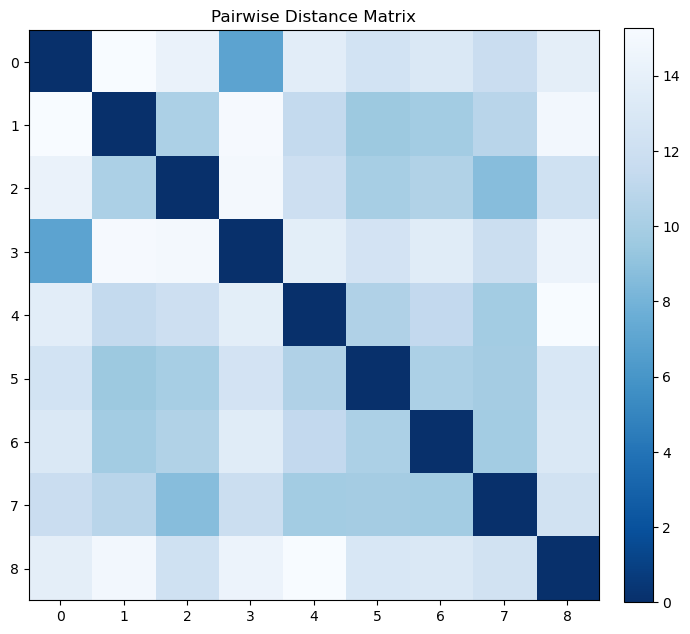

In [13]:
plot_matrix(embeddings_data, labels_data_str)

## Classification with DB

In [14]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_08_14_objects_clean"
known_classes = os.listdir(OBJECTS_ROOT)

In [15]:
def save_class_to_indices(class_to_indices: dict, filename: str):
    with open(filename, "w") as f:
        json.dump(class_to_indices, f)


def load_class_to_indices(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [16]:
total_samples = 0
class_to_indices = {c: [] for c in known_classes}
f = 2048  # Length of item vector that will be indexed
db = AnnoyIndex(f, "angular")
for c in tqdm(known_classes):
    images = glob(os.path.join(OBJECTS_ROOT, c, "*.png"))
    print(f"{len(images)} samples in the class {c}")

    for idx, img_path in enumerate(tqdm(images)):
        features = extract_features(img_path, model)
        class_to_indices[c].append(total_samples)
        db.add_item(total_samples, features)
        total_samples += 1

print(f"Total samples: {total_samples}")
db.build(10)  # 10 trees

  0%|          | 0/18 [00:00<?, ?it/s]

103 samples in the class Alnus


  0%|          | 0/103 [00:00<?, ?it/s]

205 samples in the class Betula


  0%|          | 0/205 [00:00<?, ?it/s]

146 samples in the class Corylus


  0%|          | 0/146 [00:00<?, ?it/s]

316 samples in the class Acer


  0%|          | 0/316 [00:00<?, ?it/s]

150 samples in the class Chenopodiaceae


  0%|          | 0/150 [00:00<?, ?it/s]

73 samples in the class Pinus


  0%|          | 0/73 [00:00<?, ?it/s]

52 samples in the class Poaceae


  0%|          | 0/52 [00:00<?, ?it/s]

131 samples in the class Apiaceae


  0%|          | 0/131 [00:00<?, ?it/s]

98 samples in the class Rumex


  0%|          | 0/98 [00:00<?, ?it/s]

234 samples in the class Salix


  0%|          | 0/234 [00:00<?, ?it/s]

210 samples in the class Populus tremula


  0%|          | 0/210 [00:00<?, ?it/s]

42 samples in the class Urtica


  0%|          | 0/42 [00:00<?, ?it/s]

242 samples in the class Artemisia


  0%|          | 0/242 [00:00<?, ?it/s]

99 samples in the class Picea


  0%|          | 0/99 [00:00<?, ?it/s]

113 samples in the class Tilia


  0%|          | 0/113 [00:00<?, ?it/s]

113 samples in the class Plantago


  0%|          | 0/113 [00:00<?, ?it/s]

88 samples in the class Quercus


  0%|          | 0/88 [00:00<?, ?it/s]

186 samples in the class Fraxinus


  0%|          | 0/186 [00:00<?, ?it/s]

Total samples: 2601


True

Alnus: 103
Betula: 205
Corylus: 146
Acer: 316
Chenopodiaceae: 150
Pinus: 73
Poaceae: 52
Apiaceae: 131
Rumex: 98
Salix: 234
Populus tremula: 210
Urtica: 42
Artemisia: 242
Picea: 99
Tilia: 113
Plantago: 113
Quercus: 88
Fraxinus: 186


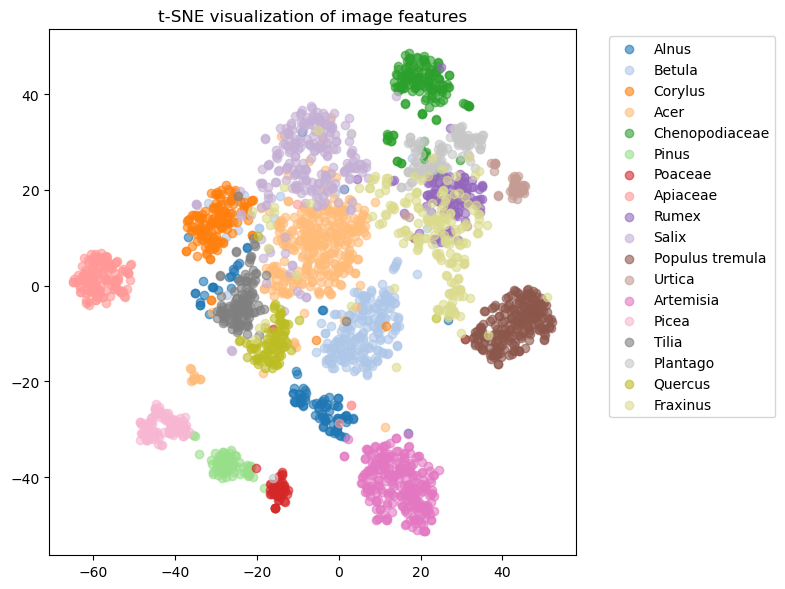

In [17]:
vectors = np.array(list(db.get_item_vector(i) for i in range(db.get_n_items())))
colors = matplotlib.colormaps["tab20"].colors

labels = [""] * vectors.shape[0]
for class_name, indices in class_to_indices.items():
    for index in indices:
        labels[index] = class_name
    print(f"{class_name}: {len(indices)}")

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(8, 6))
for i, (class_name, indices) in enumerate(class_to_indices.items()):
    mask = np.isin(range(vectors.shape[0]), indices)
    plt.scatter(
        vectors_2d[mask, 0],
        vectors_2d[mask, 1],
        label=class_name,
        color=colors[i],
        alpha=0.6,
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE visualization of image features")
plt.tight_layout()
plt.show()

In [18]:
embeddings_data = []
images = glob(os.path.join(input_dir, "*.png"))

for image_path in tqdm(images):
    embeddings_data.append(extract_features(image_path, model))

  0%|          | 0/9 [00:00<?, ?it/s]

In [19]:
def get_class(db, vector, k=5):
    neighbor_ids = db.get_nns_by_vector(vector, k, include_distances=False)
    index_to_class = {}
    for class_name, indices in class_to_indices.items():
        for index in indices:
            index_to_class[index] = class_name
    
    neighbor_classes = [index_to_class[neighbor_id] for neighbor_id in neighbor_ids]
    most_common_class = Counter(neighbor_classes).most_common(1)[0][0]
    return most_common_class

In [20]:
def plot(imgs, labels):
    num_rows = 1
    num_cols = len(imgs)
    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        squeeze=False,
        figsize=(num_cols * 3, num_rows * 5),
    )
    for col_idx, img in enumerate(imgs):
        ax = axs[0][col_idx]
        img = Image.open(imgs[col_idx])
        ax.imshow(img)
        ax.set_title(labels[col_idx])
    plt.show()

In [21]:
pred = []
for image_path in tqdm(images): 
    vector = extract_features(image_path, model)
    pred.append(get_class(db, vector, 3))

  0%|          | 0/9 [00:00<?, ?it/s]

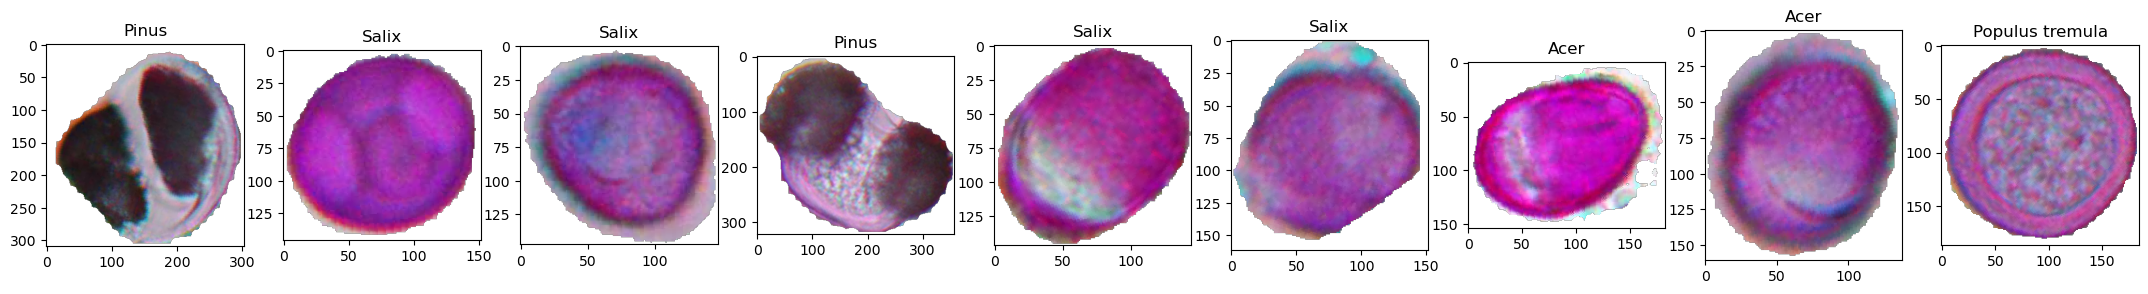

In [22]:
plot(images, pred)